In [1]:
from dataclasses import dataclass
import numpy as np
import numba as nb
from numba import njit, prange
from tqdm.auto import tqdm
from numba.typed import List, Dict
from scipy.special import factorial
from prettytable import PrettyTable 

In [2]:
%load_ext autoreload
%autoreload 2

## Layer Norm

In [3]:
from src.blocks.LayerNorm import der_bound_variance, der_bound_g, der_bounds_g, \
    der_bounds_variance, der_bounds_g_circ_variance

In [4]:
from src.blocks.LayerNorm import der_bounds_layer_norm
from src.PrintUtil import pretty_results, pretty_results_latex, pretty_max_values, pretty_max_values_latex, get_max_vals

In [28]:
# by_level = True
by_level = False

In [16]:
n = 5
k = 10
results = {
    "g": der_bounds_g(n, by_level),
    "var": der_bounds_variance(n, k, 10.0, 1.0, by_level),
    "g ° var": der_bounds_g_circ_variance(n, k, 10.0, 1.0, by_level),
    "layer norm": der_bounds_layer_norm(n, k, 10.0, 1.0, by_level)
}
print(pretty_results(n, k, dict(results)))

+-------------------------+-------+-------+----------+------------+
| Type                    | g     | var   | g ° var  | layer norm |
+-------------------------+-------+-------+----------+------------+
| (1, 0, ...)             | 0.75  | 20.00 | 32.17    | 321.71     |
| (1, 1, 0, ...)          | NAN   | 20.00 | 782.17   | 7.89E+03   |
| (2, 0, ...)             | 0.94  | 20.00 | 782.17   | 7.89E+03   |
| (1, 1, 1, 0, ...)       | NAN   | 20.00 | 7.99E+04 | 8.01E+05   |
| (2, 1, 0, ...)          | NAN   | 20.00 | 7.99E+04 | 8.01E+05   |
| (3, 0, ...)             | 1.64  | 20.00 | 7.99E+04 | 8.01E+05   |
| (1, 1, 1, 1, 0, ...)    | NAN   | 20.00 | 1.43E+07 | 1.44E+08   |
| (2, 1, 1, 0, ...)       | NAN   | 20.00 | 1.43E+07 | 1.44E+08   |
| (2, 2, 0, ...)          | NAN   | 20.00 | 1.43E+07 | 1.44E+08   |
| (3, 1, 0, ...)          | NAN   | 20.00 | 1.43E+07 | 1.44E+08   |
| (4, 0, ...)             | 3.69  | 20.00 | 1.43E+07 | 1.44E+08   |
| (1, 1, 1, 1, 1, 0, ...) | NAN   | 20.00 | 4.49

In [10]:
n = 5
results = {
    "base": der_bounds_layer_norm(n, 10, 10.0, 1.0,),
    "a-": der_bounds_layer_norm(n, 5, 10.0, 1.0,),
    "a+": der_bounds_layer_norm(n, 20, 10.0, 1.0,),
    "b--": der_bounds_layer_norm(n, 20, .1, 1.0,),
    "b-": der_bounds_layer_norm(n, 10, 1.0, 1.0,),
    "b+": der_bounds_layer_norm(n, 10, 100.0, 1.0,),
    "b++": der_bounds_layer_norm(n, 10, 1000.0, 1.0,),
}
print(pretty_results(n, 5, dict(results)))

+-------------------+----------+----------+----------+--------+----------+----------+----------+
| Type              | base     | a-       | a+       | b--    | b-       | b+       | b++      |
+-------------------+----------+----------+----------+--------+----------+----------+----------+
| (1, 0, ...)       | 321.71   | 321.71   | 321.71   | 1.73   | 18.67    | 1.67E+04 | 1.52E+06 |
| (1, 1, 0, ...)    | 7.75E+03 | 7.75E+03 | 7.75E+03 | 36.52  | 63.51    | 7.50E+06 | 7.50E+09 |
| (2, 0, ...)       | 5.87E+03 | 5.87E+03 | 5.87E+03 | 36.44  | 60.89    | 5.63E+06 | 5.63E+09 |
| (1, 1, 1, 0, ...) | 7.91E+05 | 7.91E+05 | 7.91E+05 | 58.08  | 185.68   | 7.88E+09 | 7.88E+13 |
| (2, 1, 0, ...)    | 5.28E+05 | 5.28E+05 | 5.28E+05 | 57.25  | 151.18   | 5.25E+09 | 5.25E+13 |
| (3, 0, ...)       | 2.86E+05 | 2.86E+05 | 2.86E+05 | 55.67  | 118.12   | 2.84E+09 | 2.84E+13 |
| (1, 1, 1, 1, 0)   | 1.42E+08 | 1.42E+08 | 1.42E+08 | 77.64  | 2.04E+03 | 1.42E+13 | 1.42E+18 |
| (2, 1, 1, 0, ...) | 8.89E+07

In [82]:
n = 5
k = 5
print(pretty_max_values(n, k, {
    "5 & 10.0 & 0.1 ": der_bounds_layer_norm(n, k, 10.0, .10,),
    "   & 0.1&     ": der_bounds_layer_norm(n, k, .1, .10,),
    "   & 1.0&     ": der_bounds_layer_norm(n, k, 1.0, .10,),
    "   &100.0 &     ": der_bounds_layer_norm(n, k, 100.0, .10,),
    "   &1000.0 &     ": der_bounds_layer_norm(n, k, 100.0, .10,),
    "   &       & 0.01   ": der_bounds_layer_norm(n, k, 10.0, .01,),
    "   &       &  1.0   ": der_bounds_layer_norm(n, k, 10.0, 1.0,),
}))
k = 3
print(pretty_max_values(n, k, {
    f"{k} &      &     ": der_bounds_layer_norm(n, k, 10.0, .10,),
}))
k = 10
print(pretty_max_values(n, k, {
    f"{k} &      &     ": der_bounds_layer_norm(n, k, 10.0, .10,),
}))
k = 20
print(pretty_max_values(n, k, {
    f"{k} &      &     ": der_bounds_layer_norm(n, k, 10.0, .10,),
}))

+----------------------+--------+----------+----------+----------+----------+
|                      | 1      | 2        | 3        | 4        | 5        |
+----------------------+--------+----------+----------+----------+----------+
| 5 & 10.0 & 0.1       | 18.67  | 28.56    | 104.49   | 1.49E+03 | 4.93E+03 |
|    & 0.1&            | 0.17   | 3.61     | 5.37     | 7.05     | 8.87     |
|    & 1.0&            | 1.73   | 5.20     | 6.95     | 8.71     | 10.64    |
|    &100.0 &          | 321.71 | 7.68E+03 | 7.88E+05 | 1.42E+08 | 4.39E+09 |
|    &1000.0 &         | 321.71 | 7.68E+03 | 7.88E+05 | 1.42E+08 | 4.39E+09 |
|    &       & 0.01    | 1.73   | 2.07     | 2.24     | 2.42     | 2.59     |
|    &       &  1.0    | 321.71 | 7.75E+03 | 7.91E+05 | 1.42E+08 | 4.44E+09 |
+----------------------+--------+----------+----------+----------+----------+
+-----------------+-------+-------+--------+--------+----------+
|                 | 1     | 2     | 3      | 4      | 5        |
+-----------

## Neural Network

In [18]:
from src.blocks.NeuralNet import der_bounds_neural_network

In [29]:
%%time
n = 6
k = 10
softplus = der_bounds_neural_network(n, k, 64, 1., 1.0, "softplus", by_level)
tanh = der_bounds_neural_network(n, k, 64, 1., 1.0, "tanh", by_level)
GeLU = der_bounds_neural_network(n, k, 64, 1., 1.0, "GeLU", by_level)
SWISH = der_bounds_neural_network(n, k, 64, 1., 1.0, "SWISH", by_level)
results = dict(softplus=softplus, tanh=tanh, GeLU=GeLU, SWISH=SWISH)
print(pretty_results(n, k, results))

+----------------------------+----------+----------+----------+----------+
| Type                       | softplus | tanh     | GeLU     | SWISH    |
+----------------------------+----------+----------+----------+----------+
| (1, 0, ...)                | 17.00    | 129.00   | 73.25    | 71.39    |
| (1, 1, 0, ...)             | 22.16    | 384.00   | 103.22   | 102.39   |
| (2, 0, ...)                | 50.47    | 1.02E+03 | 237.41   | 236.78   |
| (1, 1, 1, 0, ...)          | 30.16    | 896.00   | 151.46   | 122.11   |
| (2, 1, 0, ...)             | 76.31    | 2.82E+03 | 399.40   | 283.67   |
| (3, 0, ...)                | 236.94   | 8.96E+03 | 1.25E+03 | 870.75   |
| (1, 1, 1, 1, 0, ...)       | 38.33    | 1.92E+03 | 257.73   | 154.11   |
| (2, 1, 1, 0, ...)          | 125.68   | 9.98E+03 | 1.15E+03 | 500.23   |
| (2, 2, 0, ...)             | 267.71   | 2.20E+04 | 2.52E+03 | 1.06E+03 |
| (3, 1, 0, ...)             | 393.39   | 3.20E+04 | 3.67E+03 | 1.56E+03 |
| (4, 0, ...)            

In [30]:
print(pretty_max_values(n, k, results))

+----------+--------+----------+----------+----------+----------+----------+
|          | 1      | 2        | 3        | 4        | 5        | 6        |
+----------+--------+----------+----------+----------+----------+----------+
| softplus | 17.00  | 50.47    | 236.94   | 1.34E+03 | 1.33E+04 | 1.61E+05 |
| tanh     | 129.00 | 1.02E+03 | 8.96E+03 | 9.83E+04 | 1.34E+06 | 4.98E+07 |
| GeLU     | 73.25  | 237.41   | 1.25E+03 | 1.16E+04 | 1.81E+05 | 4.27E+06 |
| SWISH    | 71.39  | 236.78   | 870.75   | 5.33E+03 | 4.13E+04 | 5.91E+05 |
+----------+--------+----------+----------+----------+----------+----------+


In [27]:
print(pretty_max_values(n, k, results))

+----------+--------+----------+----------+----------+----------+----------+
|          | 1      | 2        | 3        | 4        | 5        | 6        |
+----------+--------+----------+----------+----------+----------+----------+
| softplus | 17.00  | 96.00    | 463.99   | 2.86E+03 | 1.99E+04 | 2.14E+05 |
| tanh     | 129.00 | 1.15E+03 | 9.86E+03 | 1.11E+05 | 1.51E+06 | 5.30E+07 |
| GeLU     | 73.25  | 433.50   | 2.10E+03 | 1.55E+04 | 2.10E+05 | 4.72E+06 |
| SWISH    | 71.39  | 422.34   | 2.04E+03 | 1.26E+04 | 8.74E+04 | 8.54E+05 |
+----------+--------+----------+----------+----------+----------+----------+


In [38]:
n = 5
k = 10
print(pretty_max_values(n, k, {
    "softmax  10 & 64 & 1.0" : der_bounds_neural_network(n, k, 64, 1., 1.0, "softplus"),
    
    "tanh  & & " : der_bounds_neural_network(n, k, 64, 1., 1.0, "tanh"),
    "GeLU  & & " : der_bounds_neural_network(n, k, 64, 1., 1.0, "GeLU"),
    "SWISH & & " : der_bounds_neural_network(n, k, 64, 1., 1.0, "SWISH"),
    
    f"  &16 &     " :   der_bounds_neural_network(n, k, 16, 1., 1.0, "softplus"),
    f"  &32 &     " :   der_bounds_neural_network(n, k, 32, 1., 1.0, "softplus"),
    f"  &128 &    " : der_bounds_neural_network(n, k, 2*64, 1., 1.0, "softplus"),
    f"  &256 &    " : der_bounds_neural_network(n, k, 4*64, 1., 1.0, "softplus"),
    f"  & & 0.01  " : der_bounds_neural_network(n, k, 64, .01, 1.0, "softplus"),
    f"  & & 0.1   "  : der_bounds_neural_network(n, k, 64, .1,  1.0, "softplus"),
    f"  & & 10    "  : der_bounds_neural_network(n, k, 64, 10., 1.0, "softplus"),
    f"  & & 100   " : der_bounds_neural_network(n, k, 64, 100.,1.0, "softplus"),
}))


+------------------------+--------+----------+----------+----------+----------+
|                        | 1      | 2        | 3        | 4        | 5        |
+------------------------+--------+----------+----------+----------+----------+
| softmax  10 & 64 & 1.0 | 17.00  | 50.47    | 236.94   | 1.34E+03 | 1.33E+04 |
| tanh  & &              | 129.00 | 1.02E+03 | 8.96E+03 | 9.83E+04 | 1.34E+06 |
| GeLU  & &              | 73.25  | 237.41   | 1.25E+03 | 1.16E+04 | 1.81E+05 |
| SWISH & &              | 71.39  | 236.78   | 870.75   | 5.33E+03 | 4.13E+04 |
|   &16 &                | 5.00   | 12.62    | 59.23    | 334.15   | 3.31E+03 |
|   &32 &                | 9.00   | 25.24    | 118.47   | 668.30   | 6.63E+03 |
|   &128 &               | 33.00  | 100.95   | 473.87   | 2.67E+03 | 2.65E+04 |
|   &256 &               | 65.00  | 201.90   | 947.75   | 5.35E+03 | 5.30E+04 |
|   & & 0.01             | 17.00  | 44.32    | 180.94   | 919.87   | 6.52E+03 |
|   & & 0.1              | 17.00  | 44.3

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [24]:
# Set Seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("muted")  # husl You can choose any Seaborn palette here

colors = [0, 4, 2, 1]
markers = ['o', 'x', '^', 'v']

ValueError: x and y must have same first dimension, but have shapes (8,) and (6,)

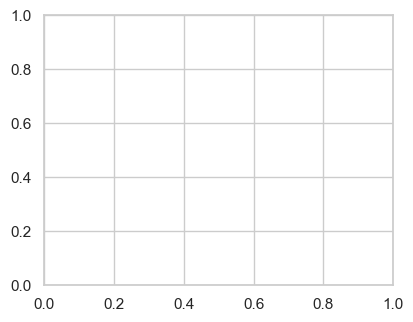

In [31]:
plt.figure(figsize=(4.5, 3.5))  # Adjust the width and height as needed

for i, row in enumerate(pretty_max_values(n, k, results).rows):
    plt.plot(list(range(1, 9)), [float(v) for v in row[1:]], label=row[0], marker=markers[i], color=f'C{colors[i]}', linestyle='-', markersize=4)
    
plt.yscale('log')
plt.title(r'$C^s$-bound of Single Layer Perceptron', fontsize=12)
plt.xlabel(r'$s$', fontsize=10, labelpad=2)  # Adjust labelpad to move xlabel closer to the plot
# plt.ylabel(r'$C^s$', fontsize=10, labelpad=2)  # Adjust labelpad to move ylabel closer to the plot
plt.legend()

# Set the border color to black
plt.gca().spines['top'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['right'].set_color('grey')

plt.tight_layout()
plt.show()

In [39]:
from src.blocks.NeuralNet import der_bound_activation

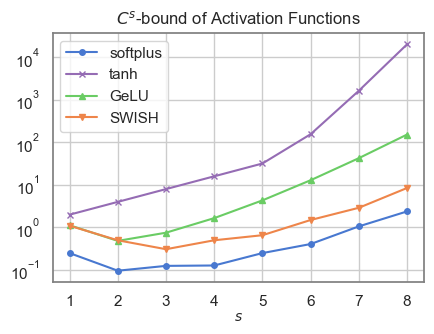

In [47]:
plt.figure(figsize=(4.5, 3.5))  # Adjust the width and height as needed

for i, row in enumerate(pretty_max_values(n, k, results).rows):
    plt.plot(list(range(1, 9)), [der_bound_activation(np.array([i], dtype=np.int16), row[0]) for i in range(1, 9)], label=row[0], marker=markers[i], color=f'C{colors[i]}', linestyle='-', markersize=4)
    
plt.yscale('log')
plt.title(r'$C^s$-bound of Activation Functions', fontsize=12)
plt.xlabel(r'$s$', fontsize=10, labelpad=2)  # Adjust labelpad to move xlabel closer to the plot
# plt.ylabel(r'$C^s$', fontsize=10, labelpad=2)  # Adjust labelpad to move ylabel closer to the plot
plt.legend()

# Set the border color to black
plt.gca().spines['top'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['right'].set_color('grey')

plt.tight_layout()
plt.savefig('tex/figs/ActivationBounds.pdf', bbox_inches='tight')
plt.show()

## Attention

In [32]:
from src.blocks.Attention import der_bounds_dp, der_bounds_softmax, der_bounds_softmax_circ_dp, der_bounds_attention, der_bounds_multi_head_attention

In [37]:
by_level = True
n = 5
input_dim = 3
sequence_length = 5
k = input_dim * sequence_length
ndim_k = 3

results = {
r"dp" : der_bounds_dp(n, input_dim * sequence_length, ndim_k, max_weight_k=1.0, max_weight_q=1.0, domain_bound=1.0, by_level=by_level),
r"Softmax" : der_bounds_softmax(n, input_dim * sequence_length),
r"Softmax°dp" : der_bounds_softmax_circ_dp(n, input_dim, sequence_length, ndim_k, max_weight_k=1.0, max_weight_q=1.0, domain_bound=1.0, by_level=by_level),
r"Attention" : der_bounds_attention(n, input_dim, sequence_length, ndim_k, max_weight_k=1.0, max_weight_q=1.0, max_weight_v=1.0, domain_bound=1.0, by_level=by_level),
r"Multi-Head Attention" : der_bounds_multi_head_attention(
    n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=1.0, max_weight_q=1.0, max_weight_w=1.0, max_weight_v=1.0, domain_bound=1.0, by_level=by_level
)
}
print(pretty_results(n, k, results))

+-------------------------+-------+---------+------------+-----------+----------------------+
| Type                    | dp    | Softmax | Softmax°dp | Attention | Multi-Head Attention |
+-------------------------+-------+---------+------------+-----------+----------------------+
| (1, 0, ...)             | 90.00 | 1.00    | 5.35E+03   | 8.03E+04  | 2.41E+05             |
| (1, 1, 0, ...)          | 90.00 | 2.00    | 2.75E+05   | 4.29E+06  | 2.57E+07             |
| (2, 0, ...)             | 90.00 | 2.00    | 2.75E+05   | 4.29E+06  | 2.57E+07             |
| (1, 1, 1, 0, ...)       | 90.00 | 6.00    | 1.09E+09   | 1.64E+10  | 2.96E+11             |
| (2, 1, 0, ...)          | 90.00 | 6.00    | 1.09E+09   | 1.64E+10  | 2.96E+11             |
| (3, 0, ...)             | 90.00 | 6.00    | 1.09E+09   | 1.64E+10  | 2.96E+11             |
| (1, 1, 1, 1, 0, ...)    | 90.00 | 24.00   | 6.36E+12   | 9.55E+13  | 6.88E+15             |
| (2, 1, 1, 0, ...)       | 90.00 | 24.00   | 6.36E+12   | 9

In [42]:
n = 5
input_dim = 5
sequence_length = 1
k = input_dim * sequence_length
ndim_k = 5

keys = [
    "1& 5 & 3 & 0.1 & 0.1 & 0.1 & 0.1 & 1.0 ",
    " &   & 3 &     &     &     &     &     ",
    " &   &10 &     &     &     &     &     ",
    " &   &20 &     &     &     &     &     ",
    " &   &   & 0.01&     &     &     &     ",
    " &   &   & 1.0 &     &     &     &     ",
    " &   &   &     & 0.01&     &     &     ",
    " &   &   &     & 1.0 &     &     &     ",
    " &   &   &     &     & 0.01&     &     ",
    " &   &   &     &     & 1.0 &     &     ",
    " &   &   &     &     &     & 0.01&     ",
    " &   &   &     &     &     & 1.0 &     ",
    " &   &   &0.001&0.001&0.001&0.001&     ",
    " &   &   &0.01 &0.01 &0.01 & 0.01&     ",
    " &   &   &1.0  &1.0  &1.0  & 1.0 &     ",
    " &   &   &     &     &     &     &0.1  ",
    " &   &   &     &     &     &     &10.0 ",
    " &   &   &     &     &     &     &100.0",
    " &   &   &     &     &     &     &     ",
]

print(pretty_max_values(n, k, {
    keys[0] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[1] : der_bounds_multi_head_attention(n, input_dim, sequence_length, 3     , ndim_v=3     , max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[2] : der_bounds_multi_head_attention(n, input_dim, sequence_length, 10    , ndim_v=10    , max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[3] : der_bounds_multi_head_attention(n, input_dim, sequence_length, 20    , ndim_v=20    , max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[4] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=1.0, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[5] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.01, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[6] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.01, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[7] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=1.0, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
    keys[8] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.01, domain_bound=1.0),
    keys[9] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=1.0, domain_bound=1.0),
    keys[10] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.01, max_weight_v=0.1, domain_bound=1.0),
    keys[11] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=1.0, max_weight_v=0.1, domain_bound=1.0),
    keys[12] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=1.0, max_weight_q=1.0, max_weight_w=1.0, max_weight_v=1.0, domain_bound=1.0),
    keys[13] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=.01, max_weight_q=.01, max_weight_w=.01, max_weight_v=.01, domain_bound=1.0),
    keys[14] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=.001, max_weight_q=.001, max_weight_w=.001, max_weight_v=.001, domain_bound=1.0),
    keys[15] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=0.1),
    keys[16] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=10.0),
    keys[17] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=100.0),
    keys[18] : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0, by_level=True),
}))

n = 5
input_dim = 10
sequence_length = 5
k = input_dim * sequence_length
ndim_k = 5
key = f" 10 & & &     &     &     &     &      "
print(pretty_max_values(n, k, {
    key : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
}))
n = 5
input_dim = 20
sequence_length = 5
k = input_dim * sequence_length
ndim_k = 5
key = f" 20 & & &     &     &     &     &      "
print(pretty_max_values(n, k, {
    key : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
}))

n = 5
input_dim = 5
sequence_length = 5
k = input_dim * sequence_length
ndim_k = 5
key = f"   & 5 &     &     &     &     &   &   "
print(pretty_max_values(n, k, {
    key : der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
}))

n = 5
input_dim = 5
sequence_length = 20
k = input_dim * sequence_length
ndim_k = 5
key = f"  & 20 &     &     &     &     &    &  "
print(pretty_max_values(n, k, {
    key: der_bounds_multi_head_attention(n, input_dim, sequence_length, ndim_k, ndim_v=ndim_k, max_weight_k=0.1, max_weight_q=0.1, max_weight_w=0.1, max_weight_v=0.1, domain_bound=1.0),
}))

+-----------------------------------------+----------+----------+----------+----------+----------+
|                                         | 1        | 2        | 3        | 4        | 5        |
+-----------------------------------------+----------+----------+----------+----------+----------+
| 1& 5 & 3 & 0.1 & 0.1 & 0.1 & 0.1 & 1.0  | 7.67     | 46.08    | 184.82   | 931.81   | 5.73E+03 |
|  &   & 3 &     &     &     &     &      | 7.67     | 45.99    | 183.98   | 920.53   | 5.53E+03 |
|  &   &10 &     &     &     &     &      | 7.70     | 46.41    | 190.35   | 1.07E+03 | 1.03E+04 |
|  &   &20 &     &     &     &     &      | 7.75     | 47.52    | 226.02   | 2.87E+03 | 1.23E+05 |
|  &   &   & 0.01&     &     &     &      | 7.90     | 54.45    | 740.55   | 6.51E+04 | 9.33E+06 |
|  &   &   & 1.0 &     &     &     &      | 7.65     | 45.91    | 183.61   | 918.01   | 5.51E+03 |
|  &   &   &     & 0.01&     &     &      | 7.65     | 45.91    | 183.61   | 918.01   | 5.51E+03 |
|  &   &  

In [45]:
from src.blocks.TransfomerBlock import der_bounds_tblock

In [46]:
n = 5
input_dim = 5
output_dim = 1
sequence_length = 1
k = input_dim * sequence_length
ndim_k = 3
mw_activ = .01
mw_nn = .001
mw_ln = .01

result, all_res = der_bounds_tblock(
    n, input_dim, output_dim, sequence_length, ndim_k, ndim_v=ndim_k, ndim_nn=64,
    max_weight_k=mw_activ, max_weight_q=mw_activ, max_weight_v=mw_activ, max_weight_w=mw_activ,
    max_weight_ln1=mw_ln/10, max_weight_a=mw_ln, max_weight_b=mw_nn, max_weight_ln2=mw_ln,
    domain_bound=1.0, verbose=2, by_level=by_level,
)
print(pretty_max_values(n, k, dict(tblock=result)))

Computing Bound for Multi-Head Attention
+--------+------+------+------+------+-------+
|        | 1    | 2    | 3    | 4    | 5     |
+--------+------+------+------+------+-------+
| tblock | 0.08 | 0.46 | 1.84 | 9.18 | 55.08 |
+--------+------+------+------+------+-------+
Computing Bound for Layer Norm 1
+--------+------+------+------+------+------+
|        | 1    | 2    | 3    | 4    | 5    |
+--------+------+------+------+------+------+
| tblock | 0.02 | 0.05 | 0.07 | 0.09 | 0.10 |
+--------+------+------+------+------+------+
Computing Bound for Neural Net
+--------+------+------+------+------+------+
|        | 1    | 2    | 3    | 4    | 5    |
+--------+------+------+------+------+------+
| tblock | 0.02 | 0.06 | 0.29 | 1.54 | 9.60 |
+--------+------+------+------+------+------+
Computing Bound for Layer Norm 2
+--------+------+------+------+------+------+
|        | 1    | 2    | 3    | 4    | 5    |
+--------+------+------+------+------+------+
| tblock | 0.17 | 0.52 | 0.69

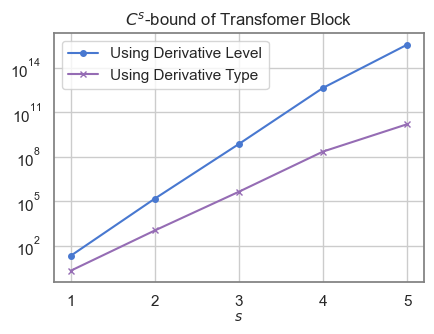

In [54]:
n = 5
input_dim = 5
output_dim = 1
sequence_length = 1
k = input_dim * sequence_length
ndim_k = 3
mw_activ = .001
mw_nn = .001
mw_ln = .001


bl_comp = [get_max_vals(der_bounds_tblock(
    n, input_dim, output_dim, sequence_length, ndim_k, ndim_v=ndim_k, ndim_nn=64,
    max_weight_k=mw_activ, max_weight_q=mw_activ, max_weight_v=mw_activ, max_weight_w=mw_activ,
    max_weight_ln1=mw_ln/10, max_weight_a=mw_ln, max_weight_b=mw_nn, max_weight_ln2=mw_ln,
    domain_bound=1.0, verbose=0, by_level=bl,
)[0], n, k) for bl in (True, False)]

plt.figure(figsize=(4.5, 3.5))  # Adjust the width and height as needed
labels = ["Using Derivative Level", "Using Derivative Type"]

for i in (0, 1):
    plt.plot(list(range(1, 6)), bl_comp[i], label=labels[i], marker=markers[i], color=f'C{colors[i]}', linestyle='-', markersize=4)
    
plt.yscale('log')
plt.title(r'$C^s$-bound of Transfomer Block', fontsize=12)
plt.xlabel(r'$s$', fontsize=10, labelpad=2)  # Adjust labelpad to move xlabel closer to the plot
# plt.ylabel(r'$C^s$', fontsize=10, labelpad=2)  # Adjust labelpad to move ylabel closer to the plot
plt.legend()

# Set the border color to black
plt.gca().spines['top'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['right'].set_color('grey')

plt.tight_layout()
plt.savefig('tex/figs/TBlockComp.pdf', bbox_inches='tight')
plt.show()

In [80]:
n = 5; input_dims = [5, 10, 20]
output_dim = 1; sequence_length = 1; k = input_dim * sequence_length
ndim_k = 3
mw_activ = .01; mw_nn = .001; mw_ln = .01
print(pretty_max_values(n, k, {
    f"{idim}&&&":
    der_bounds_tblock(
    n, idim, output_dim, sequence_length, ndim_k, ndim_v=ndim_k, ndim_nn=64,
    max_weight_k=mw_activ, max_weight_q=mw_activ, max_weight_v=mw_activ, max_weight_w=mw_activ,
    max_weight_ln1=mw_ln/10, max_weight_a=mw_ln, max_weight_b=mw_nn, max_weight_ln2=mw_ln,
    domain_bound=1.0, verbose=0)[0]
    for idim in input_dims
}))

n = 5; input_dims = 5
output_dim = 1; sequence_length = 1; k = input_dim * sequence_length
ndim_k = 3
mw_activs = (.001, .1, 1.0); mw_nn = .001; mw_ln = .01
for mw_activ in mw_activs:
    print(pretty_max_values(n, k, {
        f"&{mw_activ}&&":
        der_bounds_tblock(
        n, input_dim, output_dim, sequence_length, ndim_k, ndim_v=ndim_k, ndim_nn=64,
        max_weight_k=mw_activ, max_weight_q=mw_activ, max_weight_v=mw_activ, max_weight_w=mw_activ,
        max_weight_ln1=mw_ln/10, max_weight_a=mw_ln, max_weight_b=mw_nn, max_weight_ln2=mw_ln,
        domain_bound=1.0, verbose=0)[0]
    }))
n = 5; input_dims = 5
output_dim = 1; sequence_length = 1; k = input_dim * sequence_length
ndim_k = 3
mw_activ = .01; mw_nns = (0.0001, 0.01, 0.1); mw_ln = .01
for mw_nn in mw_nns:
    print(pretty_max_values(n, k, {
        f"&&{mw_nn}&":
        der_bounds_tblock(
        n, input_dim, output_dim, sequence_length, ndim_k, ndim_v=ndim_k, ndim_nn=64,
        max_weight_k=mw_activ, max_weight_q=mw_activ, max_weight_v=mw_activ, max_weight_w=mw_activ,
        max_weight_ln1=mw_ln/10, max_weight_a=mw_ln, max_weight_b=mw_nn, max_weight_ln2=mw_ln,
        domain_bound=1.0, verbose=0)[0]
    }))
n = 5; input_dims = 5
output_dim = 1; sequence_length = 1; k = input_dim * sequence_length
ndim_k = 3
mw_activ = .01; mw_lns = (0.0001, 0.001, 0.1); mw_nn = .001
for mw_ln in mw_lns:
    print(pretty_max_values(n, k, {
        f"&&&{mw_ln}":
        der_bounds_tblock(
        n, input_dim, output_dim, sequence_length, ndim_k, ndim_v=ndim_k, ndim_nn=64,
        max_weight_k=mw_activ, max_weight_q=mw_activ, max_weight_v=mw_activ, max_weight_w=mw_activ,
        max_weight_ln1=mw_ln/10, max_weight_a=mw_ln, max_weight_b=mw_nn, max_weight_ln2=mw_ln,
        domain_bound=1.0, verbose=0)[0]
    }))

+-------+----------+----------+----------+----------+----------+
|       | 1        | 2        | 3        | 4        | 5        |
+-------+----------+----------+----------+----------+----------+
| 5&&&  | 21.15    | 1.13E+04 | 4.81E+06 | 2.59E+09 | 2.22E+11 |
| 10&&& | 111.32   | 4.51E+05 | 1.71E+09 | 1.45E+13 | 8.70E+16 |
| 20&&& | 1.29E+03 | 1.25E+08 | 3.47E+13 | 1.85E+19 | 2.20E+24 |
+-------+----------+----------+----------+----------+----------+
+----------+-------+----------+----------+----------+----------+
|          | 1     | 2        | 3        | 4        | 5        |
+----------+-------+----------+----------+----------+----------+
| &0.001&& | 21.15 | 1.13E+04 | 4.81E+06 | 2.59E+09 | 2.22E+11 |
+----------+-------+----------+----------+----------+----------+
+--------+-------+----------+----------+----------+----------+
|        | 1     | 2        | 3        | 4        | 5        |
+--------+-------+----------+----------+----------+----------+
| &0.1&& | 21.16 | 1.13E+04 | 4

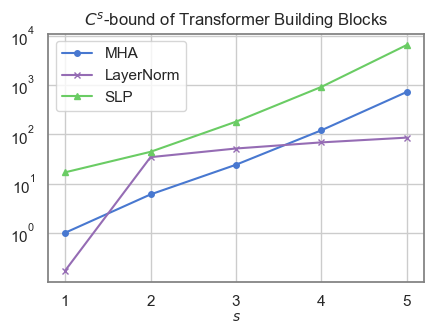

In [131]:
plt.figure(figsize=(4.5, 3.5))  # Adjust the width and height as needed

labels = "MHA", "LayerNorm", "SLP", "tblock" 
for i, r in enumerate([l for i, l in enumerate(all_res) if i not in (3, 4)]):
    plt.plot(list(range(1, 6)), r, label=labels[i], marker=markers['i'], color=f'C{colors[i]}', linestyle='-', markersize=4)
    
plt.yscale('log')
plt.title(r'$C^s$-bound of Transformer Building Blocks', fontsize=12)
plt.xlabel(r'$s$', fontsize=10, labelpad=2)  # Adjust labelpad to move xlabel closer to the plot
# plt.ylabel(r'$C^s$', fontsize=10, labelpad=2)  # Adjust labelpad to move ylabel closer to the plot
plt.legend()

# Set the border color to black
plt.gca().spines['top'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['right'].set_color('grey')

plt.tight_layout()
plt.savefig('tex/figs/BuildingBlocks.pdf', bbox_inches='tight')
plt.show()

In [73]:
tblock_b = all_res[3]

In [10]:
tblock_b

[21.154155131469444,
 11289.292499501167,
 4811756.021421812,
 2588272758.4317584,
 221900998336.1324]

### Rate computation

In [12]:
import math

In [13]:
def rate_function(N, d, s, c=1, c2=1):
    if d > 2*s:
        return (np.log(c*N)**(d - 2*s + s/d)) / (c2*N**(s/d))
    elif d == 2*s:
        return np.log(c*N) / (c*N**(1/2))
    elif d < 2*s:
        return (np.log(c*N)**(d / (2*s + 1))) / (c*N**(1/2))

In [14]:
def rate_function(N, d, s, c=1, c2=1):
    return np.log(N) / (N ** (s/d))

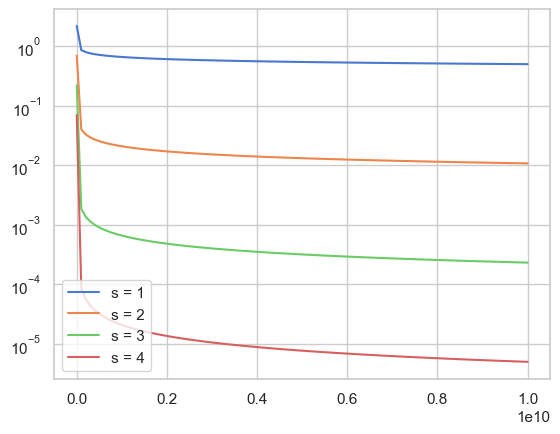

In [15]:
Ns = np.linspace(1000, 1e10, 100)
for s in range(1, 5):
    plt.plot(Ns, rate_function(Ns, 6, s), label=f"s = {s}")
plt.yscale('log')
plt.legend()
plt.show()

In [16]:
def smallest_N_for_decreasing_rate(d, bounds, c=1, c2=1):
    print(d)
    smallest_N = {}
    N = 10
    for s in range(2, len(bounds) + 1):
        rate_prev = rate_function(float(N), d, s-1, c, c2)
        rate_curr = rate_function(float(N), d, s, c, c2)
        while bounds[s-2] * rate_prev <= bounds[s-1] * rate_curr:
            N += 10
            if  N > factorial(170):
                return smallest_N
            rate_prev = rate_function(float(N), d, s-1, c, c2)
            rate_curr = rate_function(float(N), d, s, c, c2)
        print(f"{bounds[s-2]:0e}" , f"{rate_prev:0e}", f"{bounds[s-1]:0e}" , f"{rate_curr:0e}", f"{N:0e}")
        smallest_N[s] = N
        # print(f"{N:0e}")
    return smallest_N

In [11]:
import math
import numba as nb
from src.Util import factorial
@nb.njit
def rate_function(N, d, s, c=1, c2=1):
    if d > 2*s:
        return (math.log(c*N)**(d - 2*s + s/d)) / (c2*N**(s/d))
    elif d == 2*s:
        return math.log(c*N) / (c*N**(1/2))
    elif d < 2*s:
        return (math.log(c*N)**(d / (2*s + 1))) / (c*N**(1/2))
    else:
        raise ValueError("Invalid values of d and s")
        
@nb.njit
def rate_function(N, d, s, c=1, c2=1):
   return np.log(N) / (N ** (s/d))

@nb.njit
def smallest_N_for_decreasing_rate(d, bounds, c=1, c2=1):
    smallest_N = np.empty(len(bounds) - 1)
    N = 1
    for s in range(2, len(bounds) + 1):
        rate_prev = rate_function(float(N), d, s-1, c, c2)
        rate_curr = rate_function(float(N), d, s, c, c2)
        while bounds[s-2] * rate_prev <= bounds[s-1] * rate_curr:
            N *= 1.1
            if  N > 1e100:
                return smallest_N
            rate_prev = rate_function(float(N), d, s-1, c, c2)
            rate_curr = rate_function(float(N), d, s, c, c2)
        smallest_N[s-2] = N
    return smallest_N

In [74]:
import numpy as np
from tqdm.auto import tqdm

In [75]:
res_dicts = [smallest_N_for_decreasing_rate(d, np.array(get_max_vals(der_bounds_neural_network(5, d, 64, 0.1, 1.0, 'softplus'), 5, d))) for d in tqdm(range(1, 12))]
# res_dicts = [smallest_N_for_decreasing_rate(d, np.array(tblock_b)) for d in tqdm(range(1, 12))]

  0%|          | 0/11 [00:00<?, ?it/s]

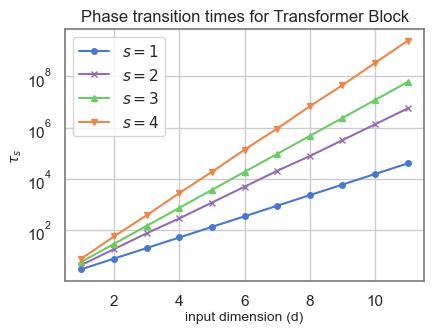

In [78]:
plt.figure(figsize=(4.5, 3.5))  # Adjust the width and height as needed

plt.plot(range(1, 12), [res_dicts[d][2-2] for d in range(11)], label=r"$s=1$", marker=markers[0], color=f'C{colors[0]}', linestyle='-', markersize=4)
plt.plot(range(1, 12), [res_dicts[d][3-2] for d in range(11)], label=r"$s=2$", marker=markers[1], color=f'C{colors[1]}', linestyle='-', markersize=4)
plt.plot(range(1, 12), [res_dicts[d][4-2] for d in range(11)], label=r"$s=3$", marker=markers[2], color=f'C{colors[2]}', linestyle='-', markersize=4)
plt.plot(range(1, 12), [res_dicts[d][5-2] for d in range(11)], label=r"$s=4$", marker=markers[3], color=f'C{colors[3]}', linestyle='-', markersize=4)
plt.xlabel(r'input dimension (d)', fontsize=10, labelpad=2)
plt.ylabel(r'$\tau_s$', fontsize=10, labelpad=2)
plt.legend()
plt.yscale('log')

plt.gca().spines['top'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['right'].set_color('grey')

plt.title("Phase transition times for Transformer Block")

plt.tight_layout()
plt.savefig('tex/figs/TransitionValues.pdf', bbox_inches='tight')
plt.show()

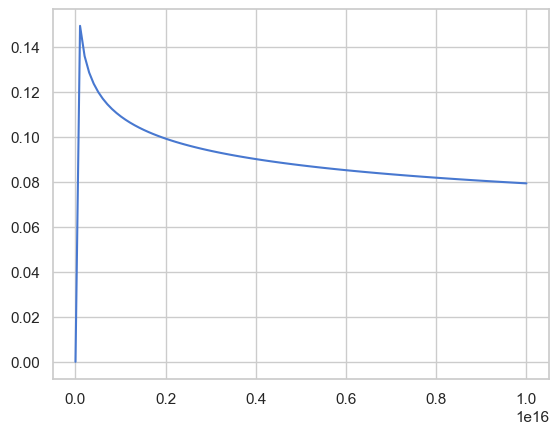

In [34]:
# Example usage:
N = np.linspace(1, 10000000000000000, 100)
d = 6
s = 1
plt.plot(N, rate_function(N, d, s))

In [10]:
def lowest_N_for_condition(d, constants):
    N = 1
    smallest_N = {}
    for s in range(2, len(constants)+1):
        while constants[s-1-1] / (N**((s-1)/d)) <= constants[s-1] / (N**(s/d)):
            N *= 2
        smallest_N[s] = N
    return smallest_N

# Example usage:
d = 3
for constants in all_res:
    lowest_N = lowest_N_for_condition(d, constants)
    print(f"Lowest N for condition:", [f"{N:0e}" for N in lowest_N.values()])

Lowest N for condition: ['2.560000e+02', '2.560000e+02', '2.560000e+02', '2.560000e+02']
Lowest N for condition: ['8.388608e+06', '8.388608e+06', '8.388608e+06', '8.388608e+06']
Lowest N for condition: ['3.200000e+01', '1.280000e+02', '2.560000e+02', '5.120000e+02']
Lowest N for condition: ['8.388608e+06', '8.388608e+06', '8.388608e+06', '8.388608e+06']
Lowest N for condition: ['2.951479e+20', '2.951479e+20', '2.951479e+20', '2.951479e+20']


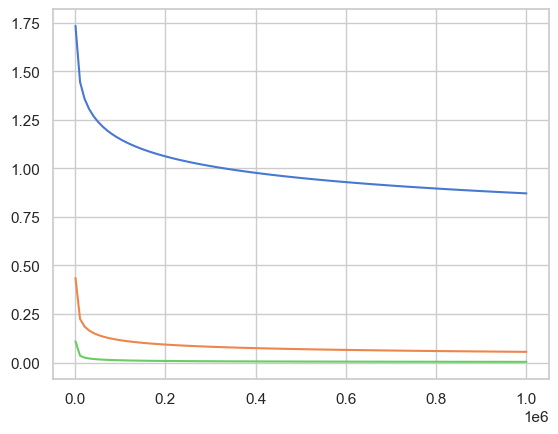

In [48]:
d = 5
Ns = np.linspace(1000, 1e6, 100)
plt.plot(Ns, np.log(Ns) / (Ns ** (1/d)))
plt.plot(Ns, np.log(Ns) / (Ns ** (2/d)))
plt.plot(Ns, np.log(Ns) / (Ns ** (3/d)))